In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import tensorflow as tf

import tensorflow.keras as K

from tensorflow_probability import distributions as tfd

from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 12})


import warnings
warnings.filterwarnings("always")

def remove_ax_window(ax):
    """
        Remove all axes and tick params in pyplot.
        Input: ax object.
    """
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
dpi = 140
x_size = 8
y_size = 4
alt_font_size = 14

save_figure = False
use_tb = False

# Example: Defining mixture of distributions of the same family. 

In [2]:
# set values for the mixture 
alphas = [0.6, 0.3, 0.1] 
means = [30, 60, 120] 
sigmas = [5, 3, 1] 

# use the tf.probability class
gm = tfd.MixtureSameFamily(mixture_distribution = tfd.Categorical(probs=alphas), 
                           components_distribution = tfd.Normal(loc = means, scale = sigmas))   

# Draw 1e5 random samples from teh mixture distribution 
prices = gm.sample(sample_shape=(int(1e5)), seed = 42) 

nd_empirical = tfd.Normal(loc = np.mean(prices), scale = np.std(prices)) 

print(np.mean(prices)) 
print(np.std(prices))

47.83535
27.69015


/usr/local/lib/python3.7/dist-packages/tree/__init__.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return _tree.flatten(structure)
/usr/local/lib/python3.7/dist-packages/tree/__init__.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return _tree.flatten(structure)
/usr/local/lib/python3.7/dist-packages/tree/__init__.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return _tree.flatten(structure)


In [47]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=100, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])
    
class DNN(tf.keras.Model):
    def __init__(self, neurons=100):
        super(DNN, self).__init__(name="DNN")
        self.neurons = neurons
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        self.out = Dense(1, activation="linear", name="out")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        return self.out(x)

In [4]:
def nnelu(input):  
  ''' computes the non-negative exponential linear unit ''' 
  return tf.add(tf.constant(1, dtype = tf.float32), tf.nn.elu(input)) 

def slice_parameter_vectors(parameter_vector): 
  ''' returns an unpacked list of parameter vectors ''' 
  return [parameter_vector[:, i*components:(i+1)*components] for i in range(no_parameters)]   

def gnll_loss(y, parameter_vector): 
  ''' computes the mean negative log-likelihood loss of y given the mixture parameters ''' 
  alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # unpack parameter vectors. 
  gm = tfd.MixtureSameFamily(
      mixture_distribution = tfd.Categorical(probs=alpha), 
      components_distribution = tfd.Normal(loc=mu, scale = sigma) 
  )
  log_likelihood = gm.log_prob(tf.transpose(y)) # evaluate log probability of y 
  return -tf.reduce_mean(log_likelihood, axis = -1)   

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)}) 

In [5]:
no_parameters = 3 
components = 1 
neurons = 200 

mon = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'auto') 

In [6]:
mdn = MDN(neurons = neurons , components = components) 
mdn.compile(loss=gnll_loss, optimizer = 'adam')  

In [7]:
dnn = DNN(neurons = neurons) 
dnn.compile(loss='mse', optimizer = 'adam') 

# Set up the linear example

In [8]:
samples = int(1e5) 

x_data = np.random.sample(samples)[:, np.newaxis].astype(np.float32) 
y_data = np.add(5*x_data, np.multiply((x_data)**2, np.random.standard_normal(x_data.shape))) 

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.5, random_state = 42) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 1), (50000, 1), (50000, 1), (50000, 1))

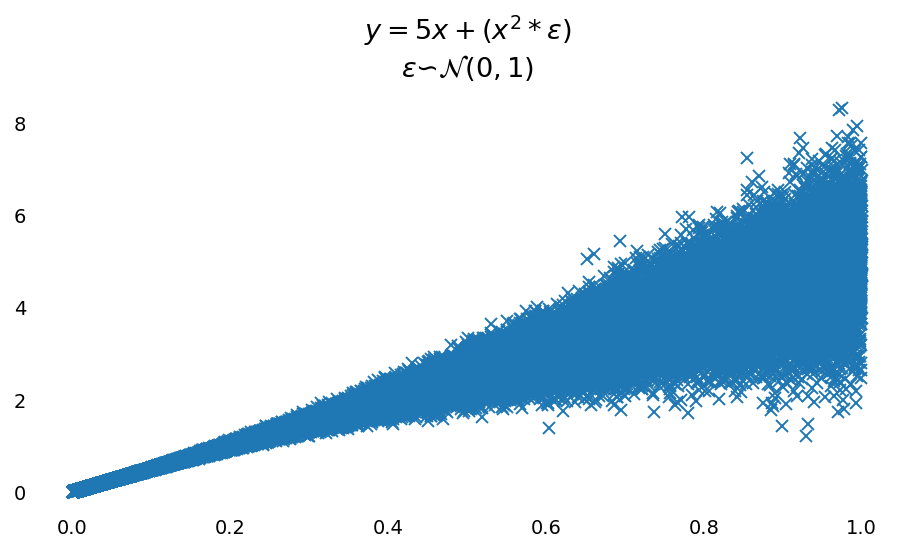

In [9]:
fig = plt.figure(figsize = (x_size, y_size), dpi = dpi) 
ax = plt.gca() 
ax.set_title(r"$y = 5x + (x^2 * \epsilon)$" + "\n" + r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize = alt_font_size)  
ax.plot(x_train, y_train, "x", alpha=1., color=sns.color_palette()[0]) 

remove_ax_window(ax)
plt.show()

In [10]:
s = np.linspace(0.,1.,int(1e3))[:, np.newaxis].astype(np.float32) 

mdn.fit(x=x_train, y=y_train, epochs = 200, validation_data=(x_test, y_test), callbacks = [mon], batch_size = 128, verbose=1)

Epoch 1/200
391/391 [==============================] - 4s 4ms/step - loss: 1.3826 - val_loss: -0.3052
Epoch 2/200
391/391 [==============================] - 1s 3ms/step - loss: -0.3132 - val_loss: -0.3497
Epoch 3/200
391/391 [==============================] - 1s 3ms/step - loss: -0.3625 - val_loss: -0.4232
Epoch 4/200
391/391 [==============================] - 1s 3ms/step - loss: -0.3612 - val_loss: -0.3166
Epoch 5/200
391/391 [==============================] - 1s 3ms/step - loss: -0.3780 - val_loss: -0.3596
Epoch 6/200
391/391 [==============================] - 1s 3ms/step - loss: -0.4035 - val_loss: -0.4535
Epoch 7/200
391/391 [==============================] - 1s 3ms/step - loss: -0.3945 - val_loss: -0.3813
Epoch 8/200
391/391 [==============================] - 1s 3ms/step - loss: -0.4031 - val_loss: -0.4201
Epoch 9/200
391/391 [==============================] - 1s 3ms/step - loss: -0.4160 - val_loss: -0.4308
Epoch 10/200
391/391 [==============================] - 1s 3ms/step - loss

In [11]:
y_pred = mdn.predict(s)

In [12]:
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

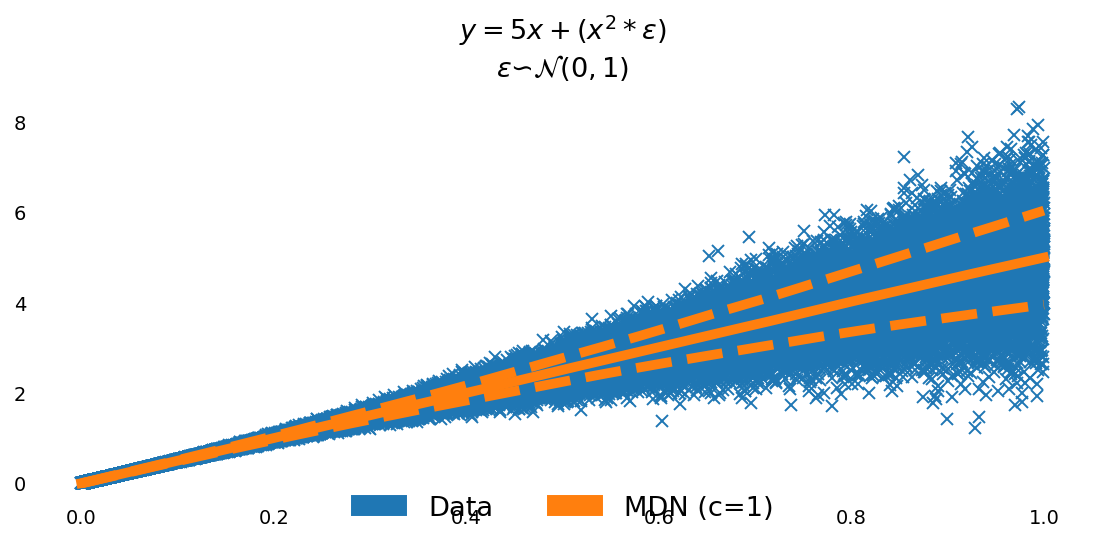

In [18]:
fig = plt.figure(figsize = (x_size, y_size), dpi = dpi) 
ax = plt.gca() 
ax.set_title(r"$y = 5x + (x^2 * \epsilon)$" + "\n" + r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize = alt_font_size)
ax.plot(x_train, y_train, "x", alpha = 1, color = sns.color_palette()[0]) 

plt.plot(s, mu_pred + sigma_pred, color = sns.color_palette()[1], linewidth = 5, linestyle = '--', markersize = 3) 
plt.plot(s, mu_pred - sigma_pred, color = sns.color_palette()[1], linewidth = 5, linestyle = '--', markersize = 3) 
plt.plot(s, mu_pred, color = sns.color_palette()[1], linewidth = 5, linestyle = '-', markersize = 3) 

remove_ax_window(ax) 

data_leg = mpatches.Patch(color = sns.color_palette()[0]) 
data_mdn = mpatches.Patch(color = sns.color_palette()[1]) 

ax.legend(handles = [data_leg, data_mdn], 
          labels = ["Data", "MDN (c=1)"], 
          loc = 9, borderaxespad = 0.1, framealpha = 1.0, fancybox = True, 
          bbox_to_anchor = (0.5, 0.05), ncol=2, shadow = True,  frameon = False,  
          fontsize = alt_font_size) 

plt.tight_layout() 

plt.show()

# Boston Housing Test

In [50]:
boston = load_boston() 
x_data = boston.data 
y_data = np.log(boston.target)[:, np.newaxis].astype(np.float32) 

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = 42, shuffle = True) 

In [51]:
min_max_scaler = MinMaxScaler() 
x_train = min_max_scaler.fit_transform(x_train) 
x_test = min_max_scaler.fit_transform(x_test)

In [52]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((354, 13), (152, 13), (354, 1), (152, 1))

In [53]:
no_parameters = 3 
components = 4
neurons = 200

In [54]:
mdn_3 = MDN(neurons = neurons, components = components) 
mdn_3.compile(loss=gnll_loss, optimizer = 'adam') 

dnn_3 = DNN(neurons = neurons) 
dnn_3.compile(loss = 'mse', optimizer = 'adam') 


In [55]:
mdn_3.fit(x_train, y_train, epochs = 200, validation_data = (x_test, y_test), callbacks = [mon], batch_size = 128, verbose = 0)

In [56]:
dnn_3.fit(x=x_train, 
          y=y_train, 
          epochs = 200, 
          validation_data = (x_test, y_test), 
          callbacks=[mon], 
          batch_size = 128, 
          verbose=0)

In [57]:
lr_3 = LinearRegression() 
lr_3.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
def plot_house(ax, index, col_index): 
  alpha, mu, sigma = slice_parameter_vectors(mdn_3.predict([x_test[index].reshape(1,-1)])) 
  gm = tfd.MixtureSameFamily(mixture_distribution = tfd.Categorical(probs=alpha), 
                             components_distribution = tfd.Normal(loc = mu, scale = sigma))    

  pyx = gm.prob(x) 
  print(pyx)

In [76]:
x_test[0,:].shape

(13,)

In [126]:
y_pred_18 = mdn_3.predict(x_test[18,:].reshape((-1,13))) 

In [127]:
alpha18, mu18, sigma18 = slice_parameter_vectors(y_pred_18)

In [128]:
gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha18),
            components_distribution=tfd.Normal(loc=mu18, scale=sigma18))

In [129]:
y_test[18]

array([3.912023], dtype=float32)

In [146]:
alpha18 = alpha18.flatten() 
mu18 = mu18.flatten()

In [147]:
ans = 0
for i in range(4): 
  ans += alpha18[i]*mu18[i] 

ans

3.886660257121548

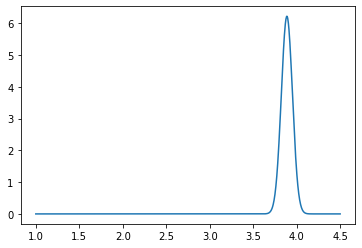

In [130]:
x = np.linspace(1,4.5,int(1e3))
plt.plot(x,gm.prob(x))

In [60]:
def plot_house(ax, index, col_index):
    print(mdn_3.predict([x_test[index].reshape(1,-1)])
    alpha, mu, sigma = slice_parameter_vectors(mdn_3.predict([x_test[index].reshape(1,-1)]))
    print(alpha, mu, sigma)
    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,       
                scale=sigma))
    pyx = gm.prob(x)
    
    ax.plot(x,pyx,alpha=1, color=sns.color_palette()[col_index], linewidth=2, label="House {:3d}".format(index))
    
    
x = np.linspace(1,4.5,int(1e3))

fig = plt.figure(figsize=(x_size,y_size), dpi=dpi)
ax = plt.gca()

plot_house(ax, 12, 0)
plot_house(ax, 13, 1)
plot_house(ax, 18, 2)
plot_house(ax, 45, 3)

ax.set_xlabel("log(MEDV in $ USD)")
ax.set_ylabel("p(log(MEDV in $ USD)| House)")

remove_ax_window(ax)

ax.legend(loc=0, borderaxespad=0.1, framealpha=1.0, fancybox=True, ncol=1, shadow=True, frameon=False, fontsize=alt_font_size)

plt.tight_layout()

if save_figure:
    plt.savefig("graphics/mdn_boston_density.png", format='png',dpi=dpi, bbox_inches='tight')
    
plt.show()

SyntaxError: ignored